<a href="https://colab.research.google.com/github/mchchoi/permutation/blob/main/Blume-Capel_adaptive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Figure size 1400x600 with 0 Axes>

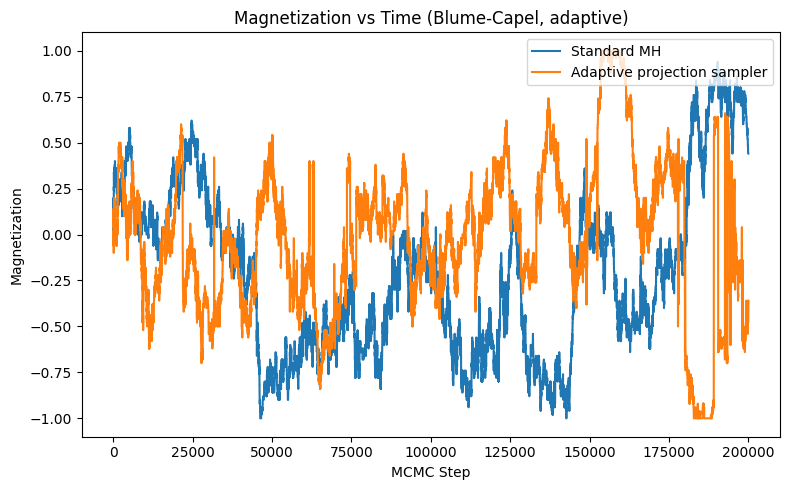

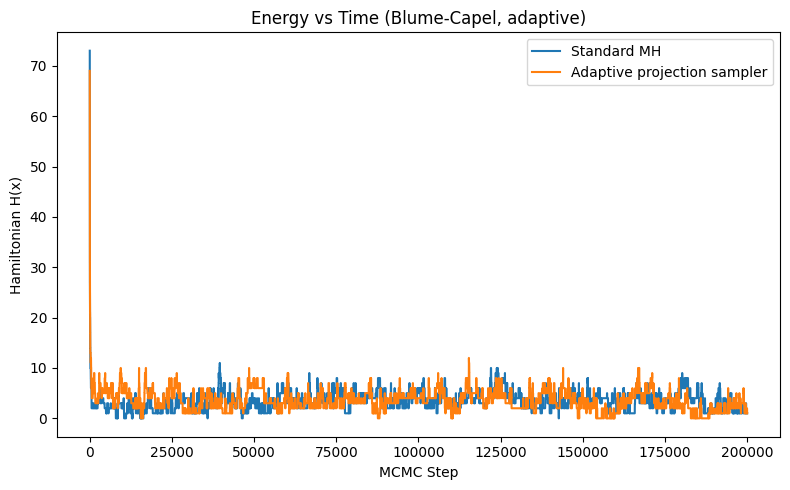

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
d = 50                 # Number of spins
n_steps = 200000       # Number of MCMC steps
beta = 3               # Inverse temperature
np.random.seed(1020)

# --- Blume-Capel Hamiltonian on the line ---
def hamiltonian(x):
    """H(x) = sum_{i=1}^{d-1} (sigma_i - sigma_{i+1})^2"""
    return np.sum((x[:-1] - x[1:])**2)

# --- Metropolis-Hastings Step for Blume-Capel ---
def metropolis_step(x):
    x_new = x.copy()
    i = np.random.randint(0, d)
    current_val = x[i]
    proposal_vals = [-1, 0, 1]
    proposal_vals.remove(current_val)
    x_new[i] = np.random.choice(proposal_vals)
    delta_H = hamiltonian(x_new) - hamiltonian(x)
    if np.random.rand() < np.exp(-beta * delta_H):
        return x_new
    else:
        return x

# --- Apply permutation Q_psi ---
def Q_psi(x, psi):
    key = x.tobytes()
    return psi[key].copy() if key in psi else x.copy()

# --- Efficient update of adaptive permutation psi ---
def update_psi_efficient(psi, history, energy_history, update_interval=50):
    if len(history) % update_interval == 0:
        energy_to_states = {}
        for i, energy in enumerate(energy_history):
            if energy not in energy_to_states:
                energy_to_states[energy] = []
            energy_to_states[energy].append(history[i])
        for energy, states in energy_to_states.items():
            if len(states) > 1:
                i, j = np.random.choice(len(states), 2, replace=False)
                x_i = states[i]
                x_j = states[j]
                xi_key, xj_key = x_i.tobytes(), x_j.tobytes()
                if xi_key not in psi and xj_key not in psi:
                    psi[xi_key] = x_j
                    psi[xj_key] = x_i
                    break

# --- Adaptive projection Metropolis step ---
def metropolis_step_adaptive_projection(x, psi):
    y1 = metropolis_step(x)
    y2 = Q_psi(metropolis_step(Q_psi(x, psi)), psi)
    return y1 if np.random.rand() < 0.5 else y2

# --- Magnetization ---
def magnetization(x):
    return np.mean(x)

# --- Initialization ---
state_std = np.random.choice([-1, 0, 1], size=d)
#state_std = np.ones(shape=d)
state_mod = state_std.copy()
mag_std = np.zeros(n_steps)
mag_mod = np.zeros(n_steps)
energy_std = np.zeros(n_steps)
energy_mod = np.zeros(n_steps)
psi = {}
history = []
energy_history = []

# --- Run both standard and adaptive projection samplers ---
for t in range(n_steps):
    state_std = metropolis_step(state_std)
    state_mod = metropolis_step_adaptive_projection(state_mod, psi)

    mag_std[t] = magnetization(state_std)
    mag_mod[t] = magnetization(state_mod)
    energy_std[t] = hamiltonian(state_std)
    energy_mod[t] = hamiltonian(state_mod)

    history.append(state_mod.copy())
    energy_history.append(energy_mod[t])
    update_psi_efficient(psi, history, energy_history)

# --- Plot results ---
plt.figure(figsize=(14, 6))

# Magnetization
plt.figure(figsize=(8, 5))
plt.plot(mag_std, label='Standard MH')
plt.plot(mag_mod, label='Adaptive projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Magnetization')
plt.title('Magnetization vs Time (Blume-Capel, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_magnetization_adaptive.png')
plt.show()

# Hamiltonian plot
plt.figure(figsize=(8, 5))
plt.plot(energy_std, label='Standard MH')
plt.plot(energy_mod, label='Adaptive projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Hamiltonian H(x)')
plt.title('Energy vs Time (Blume-Capel, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_energy_adaptive.png')
plt.show()

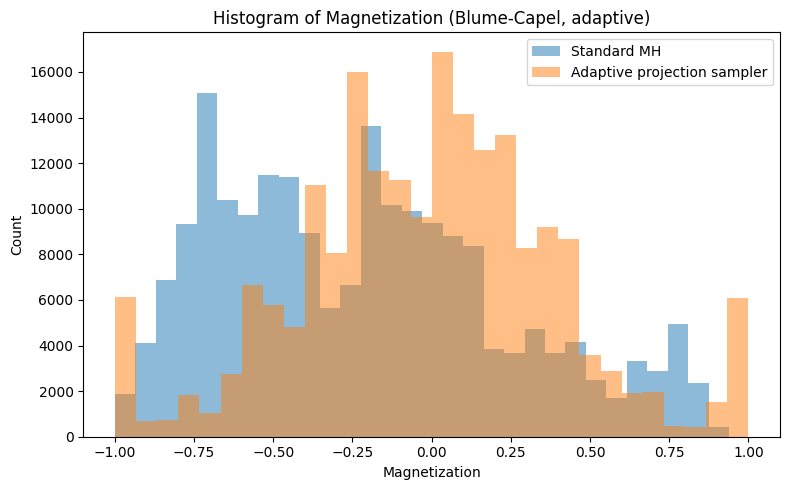

In [2]:
plt.figure(figsize=(8, 5))
plt.hist(mag_std[-200000:], bins=30, alpha=0.5, label='Standard MH', density=False)
plt.hist(mag_mod[-200000:], bins=30, alpha=0.5, label='Adaptive projection sampler', density=False)
plt.xlabel('Magnetization')
plt.ylabel('Count')
plt.title('Histogram of Magnetization (Blume-Capel, adaptive)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_histogram_adaptive.png')
plt.show()